# LEAP71 Hotfire Analysis (14th June 2024)

## HDF5 file format
AEL store their data in an HDF5 format. This file type allows for reduced file sizes for the huge amount of data obtained by AEL's DAQ.

the file contains over 100 channels with abreviations:
- `PT-`: Pressure Transducer
- `TC-`: Thermocouple
- `V-`: Valve
- `LC-`: Load Cell
- `M-`: Mass Flow Meter (Venturi)
- `X-`: Test specific sensor

For more information, see their [documentation](daq_file_format.pdf).


In [1]:
# !pip install h5py numpy scipy pandas matplotlib plotly itables openpyxl kaleido ipywidgets


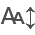


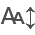

In [14]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"  # For Jupyter Notebook
import base64
from scipy.signal import spectrogram
from IPython.display import display, Markdown, Latex
from itables import init_notebook_mode
import matplotlib.pyplot as plt
import matplotlib.cm as cm
init_notebook_mode()
%matplotlib inline

# use itables
init_notebook_mode(all_interactive=True)

# Select background style
# plt.style.use('dark_background')

In [15]:
# Load the HDF5 file
f = h5py.File('20240614-007.h5', 'r')

# List all groups
print("Keys: %s" % f.keys())

# Initialize lists to store channel names, names, and units
channels = []
names = []
units = []

# Iterate over all channels
for channel in f['channels']:
    channels.append(channel)
    names.append(f['channels'][channel].attrs['name'])
    units.append(f['channels'][channel].attrs['units'])

# Create a DataFrame
df = pd.DataFrame({'Channel': channels, 'Name': names,'Units': units})
df

Keys: <KeysViewHDF5 ['channels', 'config', 'groups']>


Channel                     Name   Units
0        DAU1080_armed            DAU1080 Armed        
1    DAU1080_seq_start   DAU1080 Sequence Start        
2       DAU1094_demand           LOx AMV Demand     deg
3         DAU1094_dist         LOx AMV Distance     deg
4        DAU1094_integ       LOx AMV Integrator     deg
..                 ...                      ...     ...
104              XT823    XT823 LOX Throttle FB    Arms
105              XTC-F                     TC-F    degC
106             p_baro      Barometric Pressure  bar(a)
107          seq_start           Sequence Start        
108             t_baro  Baro Sensor Temperature    degC

[109 rows x 3 columns]

## Pressure, Thrust and Mass Flows


In [4]:
test1 = h5py.File('20240614-007.h5')
test2 = h5py.File('20240614-009.h5')

def channel_data(test, channel, downsample=1, moving_average=1):
    """
    Extracts the time and data from a channel in the test data and applies downsampling and moving average filtering.
    """
    data = test['channels'][channel]['data'][:][::downsample]
    time = test['channels'][channel]['time'][:][::downsample]
    
    if moving_average > 1:
        data = pd.Series(data).rolling(window=moving_average).mean().values
        time = pd.Series(time).rolling(window=moving_average).mean().values
        
    return time, data

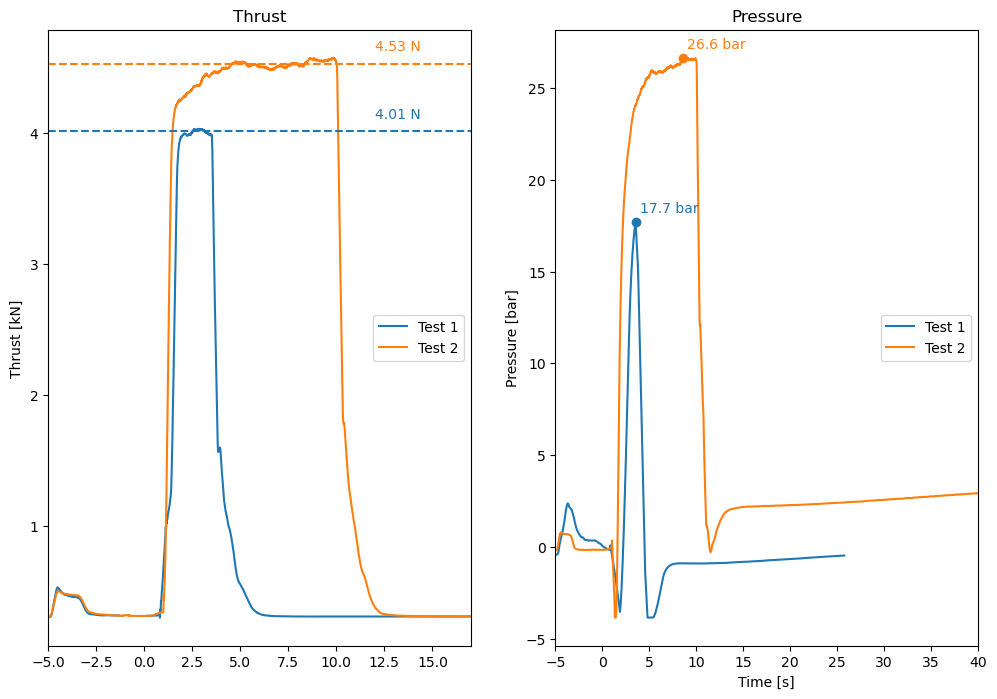

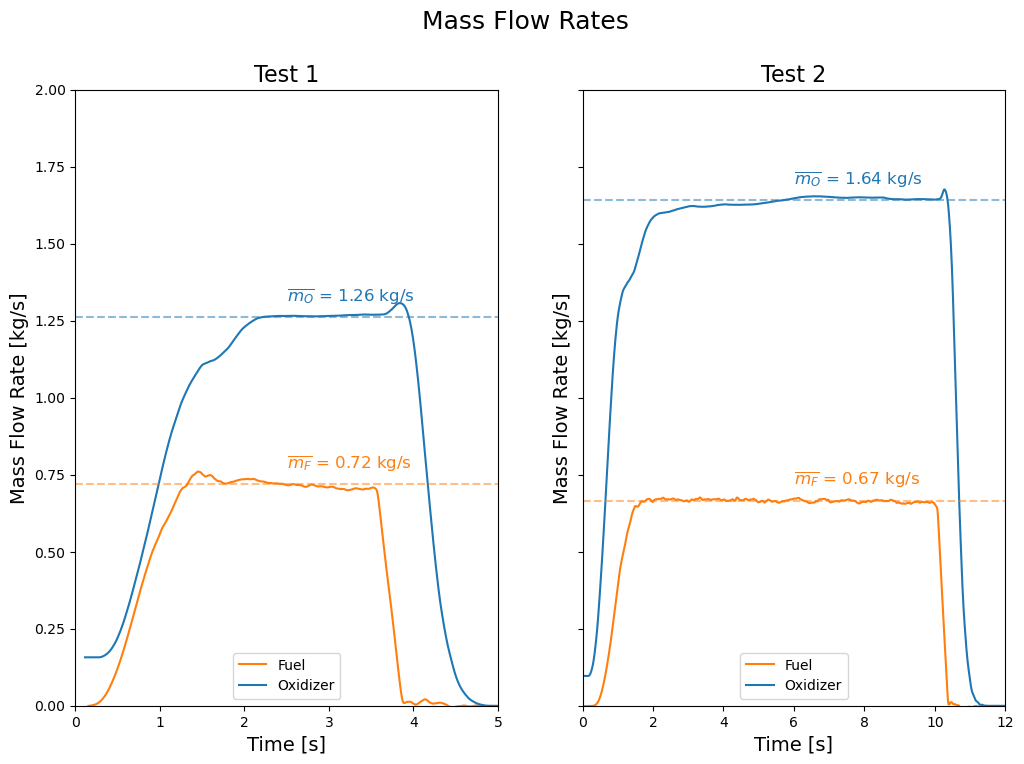

In [5]:
down = 100
ma = 30

time1, thrust1 = channel_data(test1, 'LC190', downsample=down, moving_average=ma)
time2, thrust2 = channel_data(test2, 'LC190', downsample=down, moving_average=ma)
thrust1 *= 1e-3 # Convert to kN 
thrust2 *= 1e-3 # Convert to kN

_, P1 = channel_data(test1, 'XPT-CH', downsample=down, moving_average=down)
# Ensure the same downsampling and moving average is applied to both time and data
time2, P2 = channel_data(test2, 'XPT-CH', downsample=down, moving_average=ma)

'''Thrust and Pressure profiles for Test 1 and Test 2.'''
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

# Thrust
axs[0].plot(time1, thrust1, label='Test 1', color='tab:blue')
axs[0].plot(time2, thrust2, label='Test 2', color='tab:orange')
axs[0].legend()

axs[0].set_title('Thrust')
axs[0].set_ylabel('Thrust [kN]')
axs[0].set_xlim(-5, 17)

thrust1_avg = np.mean(thrust1[(time1 > 2.5) & (time1 < 3.5)])
axs[0].axhline(y=thrust1_avg, color='tab:blue', linestyle='--', label='Average thrust (Test 1)')
axs[0].text(12, thrust1_avg+.1, f'{thrust1_avg:.2f} N', color='tab:blue')

thrust2_avg = np.mean(thrust2[(time2 > 5) & (time2 < 10)])
axs[0].axhline(y=thrust2_avg, color='tab:orange', linestyle='--', label='Average thrust (Test 2)')
axs[0].text(12, thrust2_avg+.1, f'{thrust2_avg:.2f} N', color='tab:orange')

axs[1].plot(time1, P1, label='Test 1', color='tab:blue')
axs[1].plot(time2, P2, label='Test 2', color='tab:orange')
axs[1].legend(loc='center right')

# Find max pressures and associated times for each test between 0-15s
indices1 = np.where((time1 > 0) & (time1 < 15))
P1_max = np.max(P1[indices1])
P1_max_time = time1[indices1][np.argmax(P1[indices1])]
axs[1].scatter(
    P1_max_time, P1_max, color='tab:blue', label='Max pressure (Test 1)'
)
axs[1].text(P1_max_time+0.5, P1_max+.5, f'{P1_max:.1f} bar', color='tab:blue')

indices2 = np.where((time2 > 0) & (time2 < 15))
P2_max = np.max(P2[indices2])
P2_max_time = time2[indices2][np.argmax(P2[indices2])]
axs[1].scatter(
    P2_max_time, P2_max, color='tab:orange', label='Max pressure (Test 2)'
)
axs[1].text(P2_max_time+0.5, P2_max+.5, f'{P2_max:.1f} bar', color='tab:orange')


axs[1].set_title('Pressure')
axs[1].set_ylabel('Pressure [bar]')
axs[1].set_xlabel('Time [s]')
axs[1].set_xlim(-5, 40)
plt.savefig('Figures/ThrustPressure', dpi=600)
plt.show()

t1, mF1 = channel_data(test1, 'M730', downsample=down, moving_average=ma)   # Fuel mass flow rate [kg/s]
_, mO1 = channel_data(test1, 'M801', downsample=down, moving_average=ma)   # Oxidizer mass flow rate

t2, mF2 = channel_data(test2, 'M730', downsample=down, moving_average=ma)   # Fuel mass flow rate [kg/s]
_, mO2 = channel_data(test2, 'M801', downsample=down, moving_average=ma)   # Oxidizer mass flow rate [kg/s]

# Plot mass flow rates
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 8))  # Add sharey=True
axs[0].plot(t1, mF1, label='Fuel', color='tab:orange', )
axs[0].plot(t1, mO1, label='Oxidizer', color='tab:blue')
axs[0].legend(loc = 'lower center')

# Find average mass flow rates from test1 from 2-3.2s
mF1_avg = np.mean(mF1[(t1 > 2) & (t1 < 3.2)])
mO1_avg = np.mean(mO1[(t1 > 2) & (t1 < 3.2)])
axs[0].axhline(y=mF1_avg, color='tab:orange', linestyle='--', alpha=0.5)
axs[0].axhline(y=mO1_avg, color='tab:blue', linestyle='--', alpha=0.5)
axs[0].text(2.5, mF1_avg+0.05, f'$\overline{{m_F}}$ = {mF1_avg:.2f} kg/s', color='tab:orange', fontsize=12)
axs[0].text(2.5, mO1_avg+0.05, f'$\overline{{m_O}}$ = {mO1_avg:.2f} kg/s', color='tab:blue', fontsize=12)


axs[0].set_title('Test 1', fontsize=16)
axs[0].set_xlabel('Time [s]', fontsize=14)
axs[0].set_ylabel('Mass Flow Rate [kg/s]', fontsize=14)
axs[0].set_xlim(0, 5)
axs[0].set_ylim(0, 2)

axs[1].plot(t2, mF2, label='Fuel', color='tab:orange')
axs[1].plot(t2, mO2, label='Oxidizer', color='tab:blue')
axs[1].legend(loc='lower center')

# Find average mass flow rates from test2 from 4-8s
mF2_avg = np.mean(mF2[(t2 > 4) & (t2 < 8)])
mO2_avg = np.mean(mO2[(t2 > 4) & (t2 < 8)])

axs[1].axhline(y=mF2_avg, color='tab:orange', linestyle='--', alpha=0.5)
axs[1].axhline(y=mO2_avg, color='tab:blue', linestyle='--', alpha=0.5)

axs[1].text(6, mF2_avg+0.05, f'$\overline{{m_F}}$ = {mF2_avg:.2f} kg/s', color='tab:orange', fontsize=12)
axs[1].text(6, mO2_avg+0.05, f'$\overline{{m_O}}$ = {mO2_avg:.2f} kg/s', color='tab:blue', fontsize=12)

axs[1].set_title('Test 2', fontsize=16)
axs[1].set_xlabel('Time [s]', fontsize=14)
axs[1].set_ylabel('Mass Flow Rate [kg/s]', fontsize=14)
axs[1].set_xlim(0, 12)

plt.suptitle('Mass Flow Rates', fontsize=18)
# Save the figure within figures folder - a subfolder of the current working directory
plt.savefig('Figures\\CombustionInstabilitiesFFT.png', dpi=600)
plt.show()

- For Test 2, 90.6% of the target thrust and 97% of the target pressure was achieved.
- Chamber pressures never fully levelled.
- 2.5kN DC offset in chamber PT signal, indicating possible damage to the transducer.
- Mass flow rates are fairly steady

## NASA CEA thermal calculations
From [NASA CEA](https://cearun.grc.nasa.gov/) we can calculate the theoretical chamber pressure for a given mixture ratio and chamber pressure we can estimate the following:
- OF = 2.46
- $ \rho_{c} $ = 2.07 kg/m^3
- $\gamma$ = 1.13
- $T_{ad}$ = 3508 K = 3235 °C
- $c$ = 1208 m/s

These calculations are based the assumptions
- Complete conversion of propellants to minimise gibbs free energy*
- Adiabatic combustion
- Kerosene is RP-1 refined
- Physical states accounted for


*Gibbs free energy is the energy associated with a chemical reaction that can do work. It is the energy in a system that is available to do work. The Gibbs free energy of a system at any moment in time is defined by the following equation:

$$ \Delta G_R = \sum \Delta G_{products} - \sum \Delta G_{reactants} = 0 $$

$$ \Delta G_R (T_{\text{ad}}) = 0 $$


_libraries such as [cantera](https://cantera.org/index.html) can be used to perform these calculations, however their materials database does not include propellants such as kerosene_.

## Combustion Instabilities
Combustion instabilities are a common problem experienced by rocket engines. These instabilities are highly undesirable and can be catastropic as they increase vibrational loads on the engine and can erode the thermal boundary layer of the combustion chamber leading to failure.

These oscillations are [highly complex](https://www.youtube.com/watch?v=FDHkGsYyzaA) and have posed major issues for the development of [large engines](https://www.youtube.com/watch?v=DjWiuMIGVEs), but for small engines, their effects are much less severe.



The frequency of these oscillations can be calculated using the following formula:

$$ f_{lmn} = \frac{c}{2\pi}\sqrt{\left(\frac{m}{D_c}\right)^2 + \sqrt{\frac{\gamma^2_{mn}}{R^2_c} + \frac{k^2\pi^2}{L^2_c}}} $$

where:
- $f_{lmn}$ is the frequency of the oscillation
- $c$ is the speed of sound in the combustion products
-  $m$ is the longitudinal mode number
- $D_c$ is the combustion chamber diameter
- $\gamma_{mn}$ is the $m^{th}$ zero of the $n^{th}$ Bessel function
- $R_c$ is the combustion chamber radius
- $k$ is the radial mode number
- $L_c$ is the combustion chamber length
- $n$ is the tangential mode number
- $l$ is the azimuthal mode number

In [6]:
def combustion_instability(k, gamma, Rc, Lc, c):
    """
    Calculate the frequency of a combustion instability.
    """
    f = c / (2 * np.pi) * np.sqrt(gamma**2 / Rc**2 + k**2 * np.pi**2 / Lc**2)
    
    f*=1e-3 # Convert to kHz
    # round to 2 decimal places
    f = round(f, 2)
    return f

c= 1208  # Speed of sound in combustion products [m/s]
Rc = 69.5e-3 / 2  # Combustion chamber radius [m]
Lc = 140e-3  # Combustion chamber length [m]
L1 = combustion_instability(1, 0, Rc, Lc, c)
L2 = combustion_instability(2, 0, Rc, Lc, c)
L3 = combustion_instability(3, 0, Rc, Lc, c)
T1 = combustion_instability(0, 1.841, Rc, Lc, c)
T2 = combustion_instability(0, 3.054, Rc, Lc, c)
T3 = combustion_instability(0, 4.201, Rc, Lc, c)
R1 = combustion_instability(0, 2.405, Rc, Lc, c)
R2 = combustion_instability(0, 3.832, Rc, Lc, c)
R3 = combustion_instability(0, 5.135, Rc, Lc, c)

# Create a DataFrame with harmonic numbers and associated values
df = pd.DataFrame({
    'Harmonic': ['1', '2', '3'],
    'Longitudinal [kHz]': [L1, L2, L3],
    'Tangential [kHz]': [T1, T2, T3],
    'Radial [kHz]': [R1, R2, R3]
})

df

,Harmonic,Longitudinal [kHz],Tangential [kHz],Radial [kHz]
0,1,4.31,10.19,13.31
1,2,8.63,16.90,21.20
2,3,12.94,23.24,28.41


Here we see the different frequencies of the combustion instabilities that can be expected in the combustion chamber and conditions for Test 2.

Below we investigate spectral responses of the pressure transducer signal to identify the dominant frequencies:

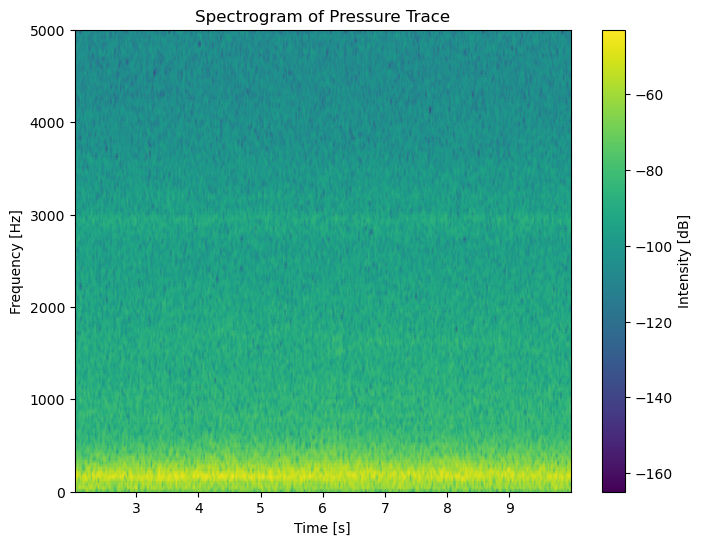

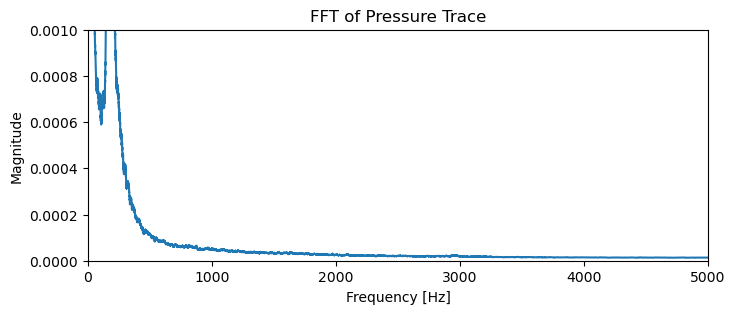

In [7]:
t, P = channel_data(test2, 'XPT-CH', downsample=1, moving_average=0)

# Focus on the interval 2-10s
mask = (t >= 2) & (t <= 10)
t_interval = t[mask]
P_interval = P[mask]

# Remove DC offset
P_interval = P_interval - np.mean(P_interval)

# Normalize the signal
P_interval = P_interval / np.max(np.abs(P_interval))

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(P_interval, fs=10000)  # Assuming 10000Hz sampling frequency

# Plot the spectrogram
plt.figure(figsize=(8, 6))
plt.pcolormesh(times + 2, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram of Pressure Trace')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Intensity [dB]')
plt.ylim(0, 5000)  # Displaying up to the Nyquist frequency
plt.savefig('Figures\CombustionInstabilitiesSpectrogram.png', dpi=600)
plt.show()

# Perform FFT on the pressure signal
N = len(P_interval)
T = 1 / 10000
xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
yf = np.fft.fft(P_interval)
yf = 2.0 / N * np.abs(yf[:N // 2])

# Use a moving average to smooth the FFT
yf = pd.Series(yf).rolling(window=80).mean().values
# Plot the FFT
plt.figure(figsize=(8, 3))
plt.plot(xf, yf)
plt.title('FFT of Pressure Trace')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0, 5000)  # Displaying up to the Nyquist frequency
plt.ylim(0, 0.001)
plt.savefig('Figures\CombustionInstabilitiesFFT.png', dpi=600)
plt.show()

There is a very minor frequency around 3kHz. This is likely the L1 mode, although is not very pronounced and highly dissimilar to calculations...

Either way, the lack of pronounced frequencies indicates that combustion instabilities are not a significant issue for this engine and that there was likely very good mixing of the propellants.

# Specific Impulse, $I_{sp}$
The specific impulse is a measure of the efficiency of a rocket engine and is defined as:
$$I_{sp} = \frac{F}{\dot{m}g_0}$$
where:
- $F$ is the thrust
- $\dot{m}$ is the mass flow rate
- $g_0$ is the acceleration due to gravity

(From here onwards we will only use Test2 data)

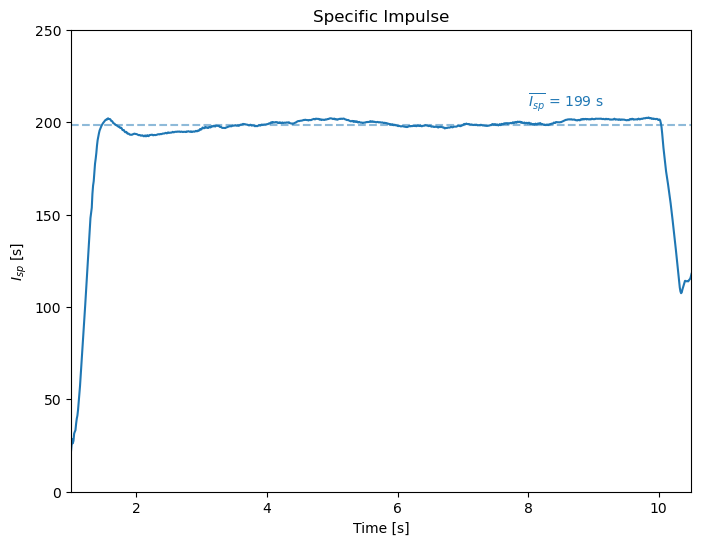

In [8]:
def spec_impulse(F, m, g0=9.81):
    return F / (m * g0)

# Retrieve mass flow rates
down = 100
ma = 30

t, mF = channel_data(test2, 'M730', downsample=down, moving_average=ma)   # Fuel mass flow rate [kg/s]
_, mO = channel_data(test2, 'M801', downsample=down, moving_average=ma)   # Oxidizer mass flow rate [
m = mF + mO  # Total mass flow rate [kg/s]

Isp = spec_impulse(thrust2*1e3, m)
plt.figure(figsize=(8, 6))
plt.plot(t, Isp, color='tab:blue')

# Find average specific impulse from test2 from 2-9s
Isp_avg = np.mean(Isp[(t > 2) & (t < 9)])
plt.axhline(y=Isp_avg, color='tab:blue', linestyle='--', alpha=0.5)
plt.text(8, Isp_avg+10, f'$\overline{{I_{{sp}}}}$ = {Isp_avg:.0f} s', color='tab:blue')


plt.title('Specific Impulse')
plt.xlabel('Time [s]')
plt.ylabel('$I_{sp}$ [s]')
plt.xlim(1, 10.5)
plt.ylim(0, 250)
plt.savefig('Figures\SpecificImpulse.png', dpi=600)
plt.show()


Specific impulse is steady at 200s, 13% above nominal

## Characteristic velocity, $c^*$
The characteristic velocity is a key measure of *combustion performance* and is defined as:
$$c^* = \frac{p_cA_t}{\dot{m}}$$
where: 
- $p_c$ is the chamber pressure,
- $A_t$ is the throat area, and
- $\dot{m}$ is the mass flow rate.

It's a useful metric as it can be shown to be a function of thermophysical properties of the combustion products only, and is largely independent of the nozzle geometry.

$$c^* = \frac{I_{sp}g_0}{C_f} = \frac{c}{C_F} = \sqrt{\frac{RT_c}{\gamma} \left(\frac{\gamma +1}{2} \right)^{\frac{\gamma + 1}{\gamma -1}}}  = f(R,T_c,\gamma)$$

where:
- $I_{sp}$ is the specific impulse
- $g_0$ is the acceleration due to gravity
- $C_F$ is the thrust coefficient
- $c$ is the speed of sound of the combustion products
- $R$ is the specific gas constant
- $T_c$ is the combustion temperature
- $\gamma$ is the ratio of specific heats

### $c^*$ Efficiency
It is often useful to compare the actual $c^*$ to the ideal $c^*$, which is the $c^*$ that would be achieved if the combustion products were all at the chamber temperature. The efficiency is defined as:
$$\eta = \frac{c^*_{\text{actual}}}{c^*_{\text{ideal}}} = \frac{p_{c,actual}}{p_{c,ideal}} $$

_from CAD it appears that the throat diameter is 40mm_

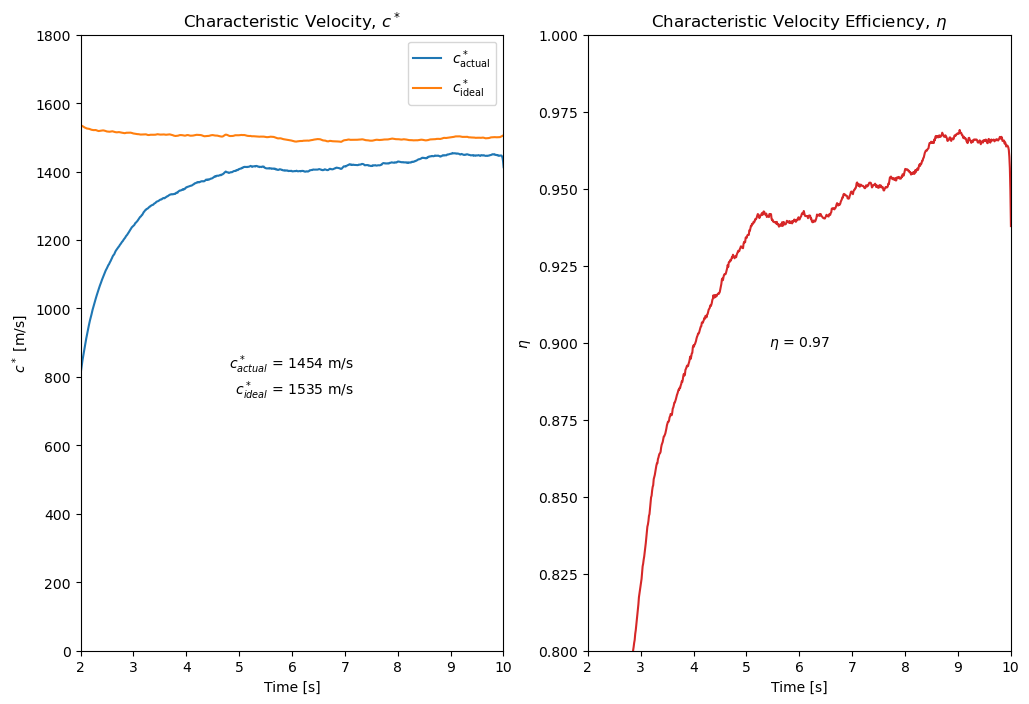

In [9]:
Dt = 40e-3  # Throat diameter [m]
At = np.pi * (Dt/2)**2  # Throat area [m^2]

# Retrieve mass flow rates
down = 100
ma = 40

t, mF = channel_data(test2, 'M730', downsample=down, moving_average=ma)     # Fuel mass flow rate [kg/s]
_, mO = channel_data(test2, 'M801', downsample=down, moving_average=ma)     # Oxidizer mass flow rate [kg/s]
_,Pc = channel_data(test2, 'XPT-CH', downsample=down, moving_average=ma)    # Chamber pressure [barg]

m = mF + mO  # Total mass flow rate [kg/s]
Pc *= 1e5  # Chamber pressure [Pa]


def charv(Pc, At, m):
    return Pc * At / m

cstar_a = charv(Pc, At, m)      # Actual characteristic velocity
cstar_i = charv(27.5*1e5, At, m)    # Ideal characteristic velocity

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
# Subplot 1: Ideal and actual characteristic velocity
axs[0].plot(t, cstar_a, label='$c^*_{\mathrm{actual}}$', color='tab:blue')
axs[0].plot(t, cstar_i, label='$c^*_{\mathrm{ideal}}$', color='tab:orange')

# Annotate in centre of subplot
cstar_a_max = np.max(cstar_a[(t > 2) & (t < 10)])
cstar_i_max = np.max(cstar_i[(t > 2) & (t < 10)])
axs[0].text(6, 800, f'$c^*_{{actual}}$ = {cstar_a_max:.0f} m/s \n $c^*_{{ideal}}$ = {cstar_i_max:.0f} m/s', ha='center', va='center')

axs[0].legend()
axs[0].set_title('Characteristic Velocity, $c^*$')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('$c^*$ [m/s]')
axs[0].set_xlim(2, 10)
axs[0].set_ylim(0, 1800)


# Subplot 2: Efficiency
cstar_eff = cstar_a / cstar_i
axs[1].plot(t, cstar_eff, color='tab:red')
axs[1].set_title('Characteristic Velocity Efficiency, $\eta$')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('$\eta$')
axs[1].set_xlim(2, 10)
axs[1].set_ylim(.8, 1)

# Annotate in centre of subplot
cstar_eff_max = np.max(cstar_eff[(t > 2) & (t < 10)])
axs[1].text(6, 0.9, f'${{\eta}}$ = {cstar_eff_max:.2f}', ha='center', va='center')
plt.savefig('Figures\CharacteristicVelocity.png', dpi=600)
plt.show()

## Coefficient of discharge, $C_d$
The coefficient of discharge is the ratio of actual volumetric flow rate to the theoretical volumetric flow rate. It is a measure of how efficiently the fluid flows through a restriction:

$$
C_d = \frac{Q_{\text{actual}}}{Q_{\text{theoretical}}} = \frac{\dot{m}}{A \sqrt{2 \rho \Delta P}}
$$


where:
- $Q$ is the volumetric flow rate
- $\dot{m}$ is the mass flow rate
- $A$ is the area of the restriction
- $\rho$ is the density of the fluid
- $\Delta P$ is the pressure drop across the restriction
- $C_d$ is the coefficient of discharge

Put simply, the higher the Cd, the lower the viscous losses and smaller the pressure drop across the orifice.

swirl injectors are more lossy than say shower heads for example.

note that there are three main orifices to calculate the $C_d$ from:
1. **oxidizer elements**
2. **fuel elements**
3. **film cooling elements**

The following assumptions made:

1. **Density at Venturi:** The density of both propellants is given from the mass flow meter. This is a reasonable assumption, but especially for self presuring propellants, this may break down as heat is added to the system.
2. **Fuel mass flow:** 10% of the mass fuel is assumed to be film cooling as per design specificion
3. **Film cooling injector pressure:** due to a faulty/ unused pressure transducer. Without a better measure of $\Delta P$, the pressure may be assumed to be equal to the fuel pressure

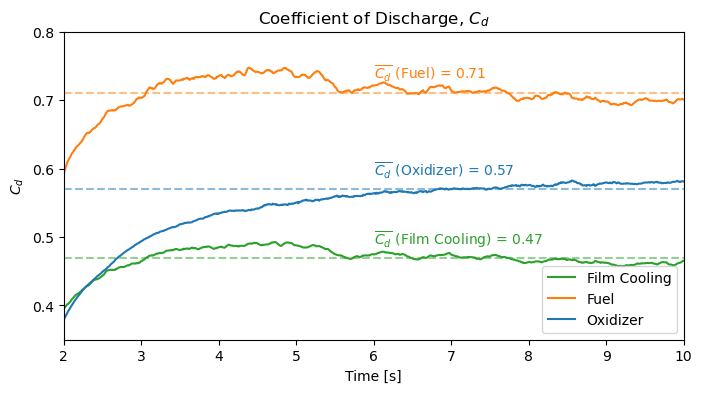

In [10]:
Nmain = 16       # Number of main elements
Nfc = 24         # Number of film cooling elements

Nf = 2           # Number of orifices per fuel element
No = 4           # Number of orifices per oxidizer element

Df = 0.89e-3    # Fuel element diameter [m]
Do = 1.17e-3    # Oxidizer element diameter [m]
Dfc = 0.4e-3    # Film cooling element diameter [m]

def Area(D):
    return np.pi * (D / 2) ** 2

Af = Area(Df)*Nmain*Nf      # Fuel element area [m^2]
Ao = Area(Do)*Nmain*No      # Oxidizer element area [m^2]
Afc = Area(Dfc)*Nfc         # Film cooling element area [m^2]

# Retrieve data from HDF5
down = 100
ma = 30
t, mf = channel_data(test2, 'M730', downsample=down, moving_average=ma)         # Fuel mass flow rate [kg/s]
_, mo = channel_data(test2, 'M801', downsample=down, moving_average=ma)         # Oxidizer mass flow rate [kg/s]
_, P_if = channel_data(test2, 'XPT-F', downsample=down, moving_average=ma)      # Injector fuel pressure [barg]
_, P_io = channel_data(test2, 'XPT-O', downsample=down, moving_average=ma)      # Injector oxidiser pressure [barg]
_, Pc = channel_data(test2, 'XPT-CH', downsample=down, moving_average=ma)       # Chamber pressure [barg]
_, rho_f = channel_data(test2, 'DT730', downsample=down, moving_average=ma)     # Fuel density [kg/m^3]
_, rho_o = channel_data(test2, 'DT801', downsample=down, moving_average=ma)     # Oxidizer density [kg/m^3]

# Find average densities from 5-30s
rho_f = np.mean(rho_f[(t > 5) & (t < 30)])
rho_o = np.mean(rho_o[(t > 5) & (t < 30)])

# Film cooling mass flow rates
fcmf = 0.1  # Film cooling mass fraction
mFC = mF * fcmf  # Film cooling mass flow rate [kg/s]

# Film cooling pressure
fcpf = 1  # Film cooling pressure ratio
Pfc = fcpf * P_if  # Film cooling pressure [Pa]

Pfc = (Pfc - Pc) * 1e5  # Convert to Pa
P_if = (P_if - Pc) * 1e5  # Convert to Pa
P_io = (P_io - Pc) * 1e5  # Convert to Pa

def Cd(m, A, rho, P1, P2):
    delta_P = P1 - P2
    valid = delta_P >= 0  
    under_root = 2 * rho * delta_P
    under_root = np.where(valid, under_root, np.nan)  # Replace invalid entries with 'nan'
    sqrt_value = np.sqrt(under_root)
    result = m / (A * sqrt_value)
    result = np.where(np.isnan(sqrt_value), np.nan, result)  # Ensure 'nan' where sqrt was not valid
    
    return result

# Calculate Cd for each element
Cd_fc = Cd(mFC, Afc, rho_f, Pfc, Pc)
Cd_f = Cd(mf, Af, rho_f, P_if, Pc)
Cd_o = Cd(mo, Ao, rho_o, P_io, Pc)

# Find averages between 5-10s
Cd_fc_avg = np.mean(Cd_fc[(t > 5) & (t < 10)])
Cd_f_avg = np.mean(Cd_f[(t > 5) & (t < 10)])
Cd_o_avg = np.mean(Cd_o[(t > 5) & (t < 10)])

plt.figure(figsize=(8, 4))
plt.plot(t, Cd_fc, label='Film Cooling', color='tab:green')
plt.plot(t, Cd_f, label='Fuel', color='tab:orange')
plt.plot(t, Cd_o, label='Oxidizer', color='tab:blue')
plt.legend()

plt.axhline(y=Cd_fc_avg, color='tab:green', linestyle='--', alpha=0.5)
plt.axhline(y=Cd_f_avg, color='tab:orange', linestyle='--', alpha=0.5)
plt.axhline(y=Cd_o_avg, color='tab:blue', linestyle='--', alpha=0.5)

plt.text(6, Cd_fc_avg+.02, f'$\\overline{{C_d}}$ (Film Cooling) = {Cd_fc_avg:.2f}', color='tab:green')
plt.text(6, Cd_f_avg+.02, f'$\\overline{{C_d}}$ (Fuel) = {Cd_f_avg:.2f}', color='tab:orange')
plt.text(6, Cd_o_avg+.02, f'$\\overline{{C_d}}$ (Oxidizer) = {Cd_o_avg:.2f}', color='tab:blue')

plt.xlabel('Time [s]')
plt.ylabel('$C_d$')
plt.title('Coefficient of Discharge, $C_d$')
plt.legend(loc ='lower right')
plt.xlim(2, 10)  # Confirm that 't' contains values within this range
plt.ylim(.35, .8)
plt.savefig('Figures\CoefficientOfDischarge.png', dpi=600)
plt.show()  



Overall these $ C_d $ values are fairly respectable and largely inline with literature values for swirl injectors. 

## Chamber Thermocouple data
The chamber thermocouples along the length of the chamber can be used to provide insights into the distribution of temperature along the chamber. 

The following steps are taken:
1. **Identify thermocouple locations**: This was acheived through the machining document and saved to `TClocations.xlsx`
2. **Average DC offset**: Each thermocouple has a DC offset. To account for this, we assume all thermocouples have the same starting temperature. This neglects the fact the chamber likely starts with variation in its temperature.

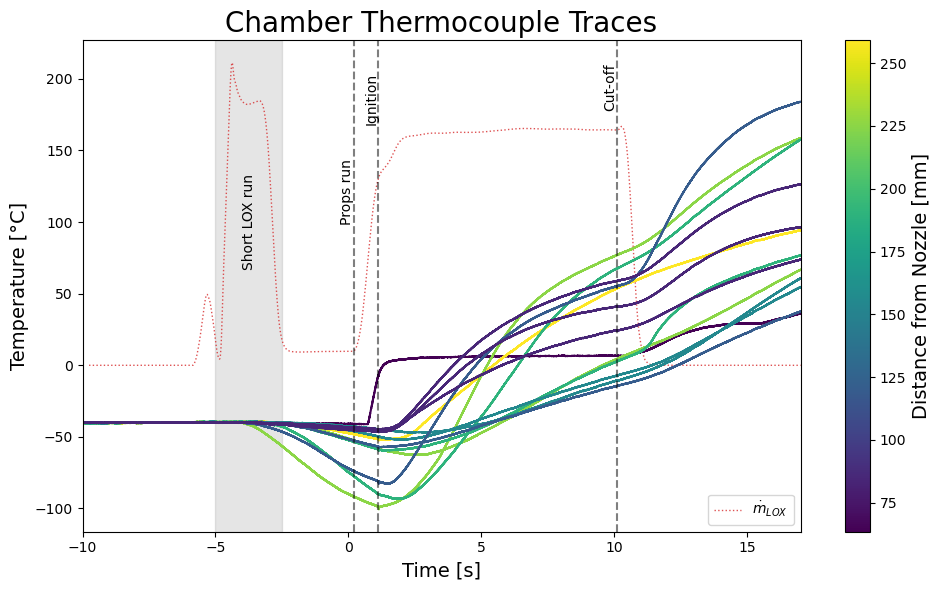

In [21]:
# Load the .h5 file
h5_file_path = '20240614-009.h5'
test = h5py.File(h5_file_path, 'r')

# Load the Excel file
file_path = 'TClocations.xlsx'
df = pd.read_excel(file_path)

# Strip any leading or trailing whitespace from column names
df.columns = df.columns.str.strip()



# Extract the thermocouples and L values
thermocouples = df['Thermocouple'].values
L_values = df['L (mm)'].values

# Define the time range for plotting
time_range = (-10, 17)

# Create a viridis colormap
colormap = plt.colormaps.get_cmap('viridis')
norm = plt.Normalize(L_values.min(), L_values.max())

# Initialize the plot
plt.figure(figsize=(10, 6))
plt.plot(t, mO*100, label='$\dot{{m}}_{{LOX}}$', color='tab:red', alpha=0.8, linewidth=1, linestyle=':')
plt.legend(loc='lower right')

#plot Lox mass flow rate with time with invisible
# Extract and plot data for each thermocouple

T_dc = []

for thermocouple, L in zip(thermocouples, L_values):
    try:
        time, data = channel_data(test, thermocouple)
        
        # Filter data within the specified time range for DC offset calculation
        mask_dc = (time >= -10) & (time <= -5)  # Change the time range to -8 to -5s
        data_dc_filtered = data[mask_dc]
        
        # Find average
        avg_temp = np.mean(data_dc_filtered)
        
        # Add to list
        T_dc.append(avg_temp)
    except:
        continue
        
T_dc_avg = np.mean(T_dc)

# Extract and plot data for each thermocouple
for thermocouple, L in zip(thermocouples, L_values):
    try:
        time, data = channel_data(test, thermocouple)
        
        # Filter data within the specified time range for DC offset calculation
        mask_dc = (time >= -10) & (time <= -5)  # Change the time range to -8 to -5s
        data_dc_filtered = data[mask_dc]
        
        # Calculate the average temperature (DC offset)
        avg_temp = np.mean(data_dc_filtered)
        
        # Filter data within the specified time range for plotting
        mask_plot = (time >= time_range[0]) & (time <= time_range[1])
        time_filtered = time[mask_plot]
        data_filtered = data[mask_plot]
        
        # Subtract the DC component
        data_dc_subtracted = data_filtered - avg_temp + T_dc_avg 
        
        # Plot the data
        plt.plot(time_filtered, data_dc_subtracted, label=thermocouple, color=colormap(norm(L)))
    except KeyError:
        # print(f"Channel {thermocouple} not found in the .h5 file.")
        continue

# Add labels, legend, and colorbar
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Temperature [°C]', fontsize=14)
plt.title('Chamber Thermocouple Traces', fontsize=20)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Distance from Nozzle [mm]', fontsize=14)

# Vertical lines and annotations
plt.axvline(x=0.2, color='k', linestyle='--', alpha=0.5)
plt.text(0.2, 100, 'Props run', color='k', fontsize=10, ha='right', rotation=90)
plt.axvline(x=1.12, color='k', linestyle='--', alpha=0.5)
plt.text(1.12, 170, 'Ignition', color='k', fontsize=10, ha='right', rotation=90)
plt.axvline(x=10.1, color='k', linestyle='--', alpha=0.5)
plt.text(10.1, 180, 'Cut-off', color='k', fontsize=10, ha='right', rotation=90)

# fill between -5, -2.5s
plt.axvspan(-5, -2.5, color='gray', alpha=0.2)
plt.text(-3.75, 100, 'Short LOX run', color='k', fontsize=10, ha='center', va='center', rotation=90)
plt.xlim(time_range)
plt.tight_layout()
plt.savefig('Figures\ChamberThermocouples.png', dpi=600)
plt.show()


In [12]:
# Function to encode image to base64
def encode_image(image_file):
    with open(image_file, 'rb') as image:
        encoded_image = base64.b64encode(image.read()).decode('ascii')
    return encoded_image

# Use dark style for plotly
px.defaults.template = 'plotly_white'

# Load the .h5 file
h5_file_path = '20240614-009.h5'
test = h5py.File(h5_file_path, 'r')

# Load the Excel file
file_path = 'TClocations.xlsx'
df = pd.read_excel(file_path)

# Strip any leading or trailing whitespace from column names
df.columns = df.columns.str.strip()

# Extract the thermocouples and L values
thermocouples = df['Thermocouple'].values
L_values = df['L (mm)'].values

# Define the time range for plotting
time_range = (-5, 17)

# List of existing thermocouples
existing_thermocouples = [
    'XT-01', 'XT-02', 'XT-03', 'XT-04', 'XT-07', 'XT-08', 
    'XT-11', 'XT-12', 'XT-15', 'XT-16', 'XT-21', 'XT-22', 'XT-23'
]


# Prepare data for plotting
plot_data = []

# Create a dictionary to store L values for fast lookup
L_dict = dict(zip(thermocouples, L_values))

for thermocouple in existing_thermocouples:
    time, data = channel_data(test, thermocouple, 800, 30)
    L = L_dict[thermocouple]
    
    # Filter data within the specified time range for DC offset calculation
    mask_dc = (time >= -10) & (time <= -5)
    data_dc_filtered = data[mask_dc]
    
    # Calculate the average temperature (DC offset)
    avg_temp = np.mean(data_dc_filtered)
    
    # Filter data within the specified time range for plotting
    mask_plot = (time >= time_range[0]) & (time <= time_range[1])
    time_filtered = time[mask_plot]
    data_filtered = data[mask_plot]
    
    # Subtract the DC component
    data_dc_subtracted = data_filtered - avg_temp + T_dc_avg
    
    # Combine data for plotting
    plot_data.append(np.column_stack((time_filtered, np.full_like(time_filtered, L), data_dc_subtracted)))

# Combine all data into a single NumPy array
plot_data = np.vstack(plot_data)

# Convert the array to a DataFrame
df_plot = pd.DataFrame(plot_data, columns=['Time', 'Distance from Nozzle (mm)', 'Temperature'])
df_plot['Time'] = df_plot['Time'].round(2)

# Reduce number of frames
# Reduce the number of frames by sampling unique 'Time' values
unique_times = sorted(df_plot['Time'].unique())
sampled_times = unique_times[::2]  

df_plot = df_plot[df_plot['Time'].isin(sampled_times)]

# # Debugging information
# print(f"Number of thermocouples processed: {len(existing_thermocouples)}")
# print(f"Number of data points: {len(plot_data)}")

# # Ensure the DataFrame is not empty
# if df_plot.empty:
#     raise ValueError("The DataFrame is empty. Please check the data extraction logic.")

# Define global min and max for the colorscale
color_min = df_plot['Temperature'].min()
color_max = df_plot['Temperature'].max()

# Encode the image
encoded_image = encode_image('fullengine.png')

# Create the animated plot with Plotly
fig = px.scatter(df_plot, x='Distance from Nozzle (mm)', y='Temperature', color='Temperature',
                 animation_frame='Time', range_y=[-150, 200],
                 labels={'Distance from Nozzle [mm]': 'Distance from Nozzle [mm]', 'Temperature': 'Temperature [°C]'},
                 color_continuous_scale='cividis')

duration = 10


fig.update_layout(
    title='Temperature Distribution Over Time',
    xaxis_title='Distance from Nozzle [mm]',
    yaxis_title='Temperature [°C]',
    coloraxis=dict(
        colorbar=dict(title='Temperature [°C]'),
        cmin=color_min,
        cmax=color_max,
        showscale=False  # Disable the colorbar
        
    ),
    images=[dict(
        source='data:image/png;base64,{}'.format(encoded_image),
        xref="paper", yref="paper",
        x=0.5, y=0.5,
        sizex=1, sizey=1,
        xanchor="center", yanchor="middle",
        opacity=0.3,
        layer="below"
    )],

    updatemenus=[{
        'buttons': [{
            'args': [None, {'frame': {'duration': duration, 'redraw': True}, 'fromcurrent': True}],
            'label': 'Play',
            'method': 'animate'
        }, {
            'args': [[None], {'frame': {'duration': duration, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': duration}}],
            'label': 'Pause',
            'method': 'animate'
        }],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Time:',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 0, 'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': [{
            'args': [
                [time],
                {'frame': {'duration': duration, 'redraw': True}, 'mode': 'immediate', 'transition': 0}
            ],
            'label': str(time),
            'method': 'animate'
        } for time in sorted(df_plot['Time'].unique())]
    }]
)


fig.write_html('Figures\TemperatureDistribution.html')
# fig.show()

### [Animated visualisation](Figures\TemperatureDistribution.html)
The link in the header provides an html animation to visualise how temperature varies with time across the engine.

_(pause and replay the animation for it to run faster)_

# Total heat transfer
With injector fuel transducers, we can calculate the total heat transfer to the fuel:
$$ Q = mC_p(T_{\text{out}} - T_{\text{in}}) $$
where:
- $Q$ is the total heat transfer across chamber wall
- $m$ is the fuel mass flow rate `M730` 
- $C_p$ is the specific heat capacity of fuel 
- $T_{\text{out}}$ is the outlet temperature (fuel injector manifold - `XTC-F`)
- $T_{\text{in}}$ is the inlet temperature (tank - `TC731`)


Given that these are 'wet' temperatures, we can assume fairly good accuracy for the heat transfer calculation.


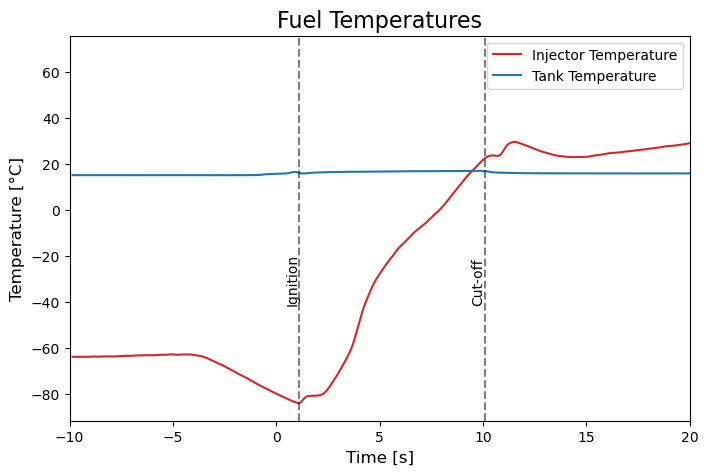

In [13]:
cp = 2.01e3  # Specific heat capacity of kerosene [J/kgK]

down=100
ma=30

t, Tout = channel_data(test2, 'XTC-F', downsample=down, moving_average=ma)
_, Tin = channel_data(test2, 'TC731', downsample=down, moving_average=ma)
_, mF = channel_data(test2, 'M730', downsample=down, moving_average=ma)
# Find average temperature between 2-7s
# Tin = np.mean(Tin[(t > 2) & (t < 7)])

plt.figure(figsize=(8, 5))
plt.plot(t, Tout, label='Injector Temperature', color='tab:red')
plt.plot(t, Tin, label='Tank Temperature', color='tab:blue')
plt.legend()
plt.axvline(x=1.12, color='k', linestyle='--', alpha=0.5)
plt.text(1.12, -40, 'Ignition', color='k', fontsize=10, ha='right', rotation=90)

plt.axvline(x=10.1, color='k', linestyle='--', alpha=0.5)
plt.text(10.1, -40, 'Cut-off', color='k', fontsize=10, ha='right', rotation=90)
plt.title('Fuel Temperatures', fontsize=16)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Temperature [°C]', fontsize=12)
plt.xlim(-10, 20)
plt.savefig('Figures\FuelTemperatures.png', dpi=600)
plt.show()

Here we see the thermocouple reading from the fuel injector is around -63°C as LOX is run through the engine prior to testing. As a result $\Delta T < 0$ for most of the run and a representative value of heat transfer cannot be calculated.